In [5]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
M = 1.0  # mass of the cart
m = 0.1  # mass of the pole
g = 9.8  # acceleration due to gravity, positive for the direction
l = 0.5  # half-length of the pole
mu_c = 0.0005  # coefficient of friction of the cart
mu_p = 0.00002  # coefficient of friction of the pole
actions = np.array([10, -10])  # possible actions (force on the cart)
delta_t = 0.02  # time step for integration
gamma = 0.99  # discount factor

# Discretization of the state space
theta_bins = np.linspace(-12, 12, 6)  # theta discretization
x_bins = np.linspace(-2.4, 2.4, 3)  # x discretization
theta_dot_bins = np.array([-50, 50])  # theta_dot discretization (open-ended)
x_dot_bins = np.array([-0.5, 0.5])  # x_dot discretization (open-ended)

# Initialize policy and value function
policy = np.zeros((len(theta_bins), len(x_bins), len(theta_dot_bins), len(x_dot_bins), len(actions)))
for i in range(len(theta_bins)):
    for j in range(len(x_bins)):
        for k in range(len(theta_dot_bins)):
            for l in range(len(x_dot_bins)):
                policy[i, j, k, l] = np.array([0.5, 0.5])  # Initialize with a random policy
state_values = np.zeros((len(theta_bins), len(x_bins), len(theta_dot_bins), len(x_dot_bins)))

# Define the reward function
def reward(theta, x):
    if abs(theta) <= 12 and abs(x) <= 2.4:
        return 1  # Reward for keeping the pole balanced
    else:
        return -1  # Penalty for failing to keep the pole balanced

# Define the dynamics of the system
def dynamics(theta, x, theta_dot, x_dot, force):
    sin_theta = np.sin(np.radians(theta))
    cos_theta = np.cos(np.radians(theta))
    theta_ddot = (g * sin_theta + cos_theta * (-force - m*l*theta_dot**2*sin_theta + mu_c * np.sign(x_dot)) / (M + m)) / \
                 (l * (4/3 - m*cos_theta**2 / (m + M)))
    x_ddot = (force + m*l*(theta_dot**2*sin_theta - theta_ddot*cos_theta) - mu_c*np.sign(x_dot)) / (M + m)
    return theta_ddot, x_ddot

# Policy Iteration Algorithm
def policy_iteration(policy, state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins, discount_factor=1.0, max_iterations=1000):
    is_value_changed = True
    iterations = 0
    while is_value_changed and iterations < max_iterations:
        is_value_changed = False
        iterations += 1
        # Policy Evaluation
        for i in range(len(theta_bins)):
            for j in range(len(x_bins)):
                for k in range(len(theta_dot_bins)):
                    for l in range(len(x_dot_bins)):
                        v = state_values[i, j, k, l]
                        action_values = np.zeros(len(actions))
                        for action_index, action in enumerate(actions):
                            theta_ddot, x_ddot = dynamics(theta_bins[i], x_bins[j], theta_dot_bins[k], x_dot_bins[l], action)
                            # Update state with Euler's method
                            new_theta_dot = theta_dot_bins[k] + theta_ddot * delta_t
                            new_x_dot = x_dot_bins[l] + x_ddot * delta_t
                            new_theta = theta_bins[i] + new_theta_dot * delta_t
                            new_x = x_bins[j] + new_x_dot * delta_t
                            # Discretize new state
                            new_i = min(len(theta_bins) - 1, max(0, np.digitize(new_theta, theta_bins) - 1))
                            new_j = min(len(x_bins) - 1, max(0, np.digitize(new_x, x_bins) - 1))
                            new_k = 0 if new_theta_dot < 0 else 1
                            new_l = 0 if new_x_dot < 0 else 1
                            # Calculate the action value
                            action_values[action_index] = reward(new_theta, new_x) + discount_factor * state_values[new_i, new_j, new_k, new_l]
                        # Select the best action value and update the value function
                        best_action_value = np.max(action_values)
                        state_values[i, j, k, l] = best_action_value
                        # Update the policy
                        best_action = np.argmax(action_values)
                        if policy[i, j, k, l][best_action] != 1.0:
                            is_value_changed = True
                        policy[i, j, k, l] = np.eye(len(actions))[best_action]

        # Policy Improvement
        for i in range(len(theta_bins)):
            for j in range(len(x_bins)):
                for k in range(len(theta_dot_bins)):
                    for l in range(len(x_dot_bins)):
                        old_action = np.argmax(policy[i, j, k, l])
                        action_values = np.zeros(len(actions))
                        for action_index, action in enumerate(actions):
                            theta_ddot, x_ddot = dynamics(theta_bins[i], x_bins[j], theta_dot_bins[k], x_dot_bins[l], action)
                            # Update state with Euler's method
                            new_theta_dot = theta_dot_bins[k] + theta_ddot * delta_t
                            new_x_dot = x_dot_bins[l] + x_ddot * delta_t
                            new_theta = theta_bins[i] + new_theta_dot * delta_t
                            new_x = x_bins[j] + new_x_dot * delta_t
                            # Discretize new state
                            new_i = min(len(theta_bins) - 1, max(0, np.digitize(new_theta, theta_bins) - 1))
                            new_j = min(len(x_bins) - 1, max(0, np.digitize(new_x, x_bins) - 1))
                            new_k = 0 if new_theta_dot < 0 else 1
                            new_l = 0 if new_x_dot < 0 else 1
                            # Calculate the action value
                            action_values[action_index] = reward(new_theta, new_x) + discount_factor * state_values[new_i, new_j, new_k, new_l]
                        # Update the policy
                        best_action = np.argmax(action_values)
                        if best_action != old_action:
                            is_value_changed = True
                        policy[i, j, k, l] = np.eye(len(actions))[best_action]
    return policy, state_values

# Run the policy iteration
optimal_policy, optimal_state_values = policy_iteration(policy, state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins)


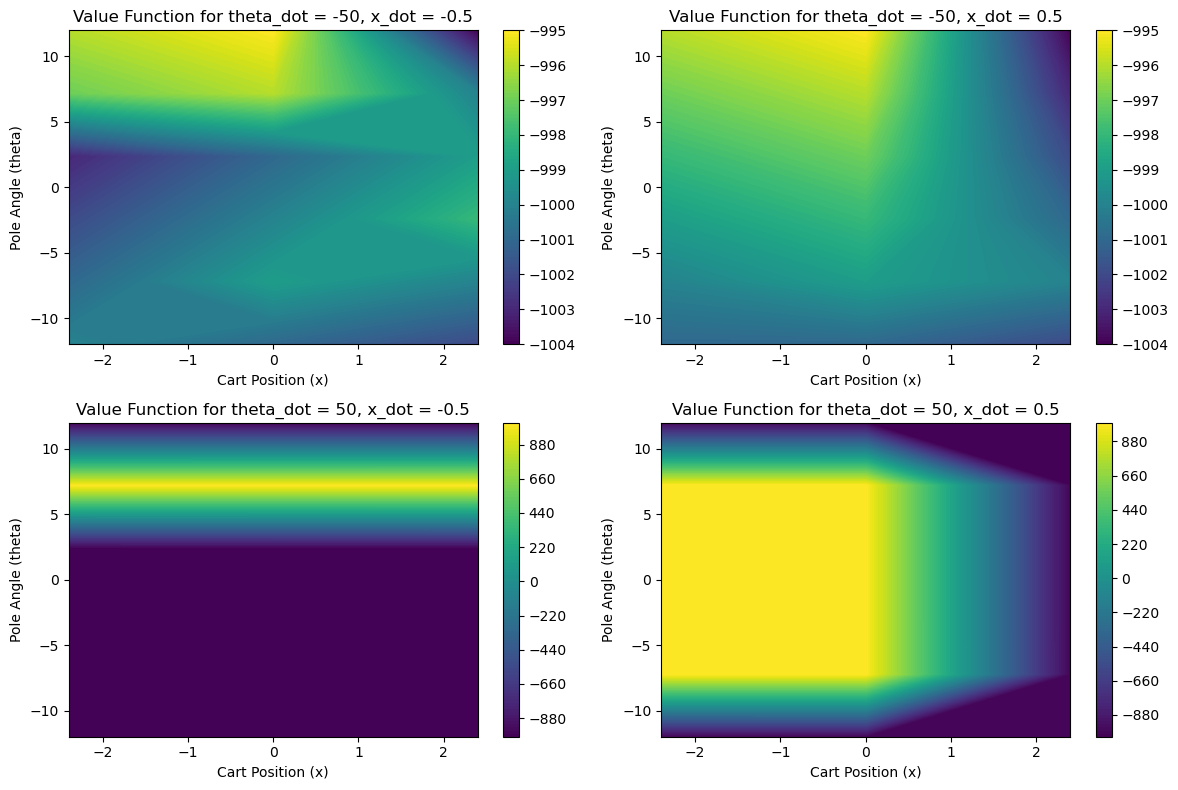

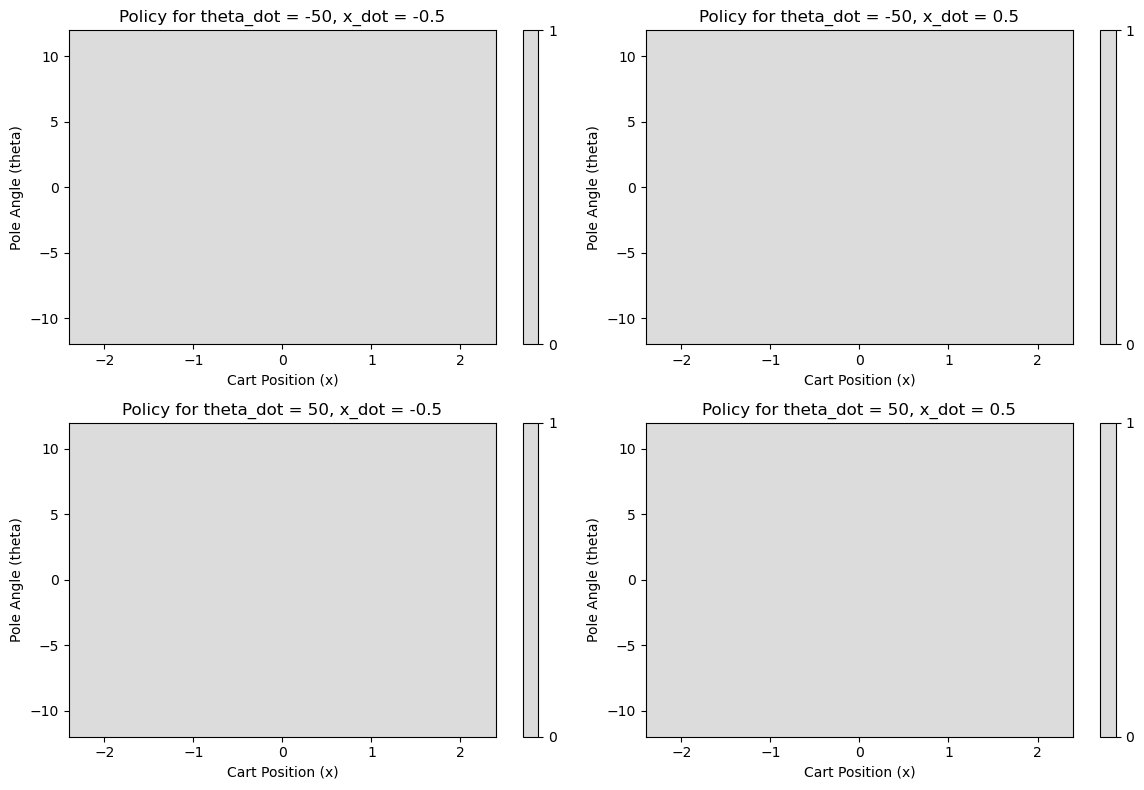

In [6]:

# Define the index bins for theta_dot and x_dot that we want to plot
theta_dot_index_to_plot = [0, 1]  # -50 and 50 in theta_dot_bins
x_dot_index_to_plot = [0, 1]  # -0.5 and 0.5 in x_dot_bins

# Generate the plots of the value function with respect to theta and x for selected theta_dot and x_dot
def plot_value_function_and_policy(state_values, policy, theta_bins, x_bins, theta_dot_bins, x_dot_bins):
    fig, ax = plt.subplots(len(theta_dot_index_to_plot), len(x_dot_index_to_plot), figsize=(12, 8))
    
    # Plot value function
    for i, theta_dot_idx in enumerate(theta_dot_index_to_plot):
        for j, x_dot_idx in enumerate(x_dot_index_to_plot):
            value_function_slice = state_values[:, :, theta_dot_idx, x_dot_idx]
            policy_slice = policy[:, :, theta_dot_idx, x_dot_idx, :]
            X, Y = np.meshgrid(x_bins, theta_bins)
            ax[i, j].contourf(X, Y, value_function_slice, cmap='viridis', levels=100)
            ax[i, j].set_title(f'Value Function for theta_dot = {theta_dot_bins[theta_dot_idx]}, x_dot = {x_dot_bins[x_dot_idx]}')
            ax[i, j].set_xlabel('Cart Position (x)')
            ax[i, j].set_ylabel('Pole Angle (theta)')
            plt.colorbar(ax[i, j].contourf(X, Y, value_function_slice, cmap='viridis', levels=100), ax=ax[i, j])

    plt.tight_layout()
    plt.show()
    
    # Plot policy
    fig, ax = plt.subplots(len(theta_dot_index_to_plot), len(x_dot_index_to_plot), figsize=(12, 8))
    
    for i, theta_dot_idx in enumerate(theta_dot_index_to_plot):
        for j, x_dot_idx in enumerate(x_dot_index_to_plot):
            policy_slice = np.argmax(policy[:, :, theta_dot_idx, x_dot_idx, :], axis=-1)
            X, Y = np.meshgrid(x_bins, theta_bins)
            ax[i, j].contourf(X, Y, policy_slice, cmap='coolwarm', levels=np.arange(policy.shape[-1]))
            ax[i, j].set_title(f'Policy for theta_dot = {theta_dot_bins[theta_dot_idx]}, x_dot = {x_dot_bins[x_dot_idx]}')
            ax[i, j].set_xlabel('Cart Position (x)')
            ax[i, j].set_ylabel('Pole Angle (theta)')
            plt.colorbar(ax[i, j].contourf(X, Y, policy_slice, cmap='coolwarm', levels=np.arange(policy.shape[-1])), ax=ax[i, j])

    plt.tight_layout()
    plt.show()

# Call the function to plot the value function and policy
plot_value_function_and_policy(optimal_state_values, optimal_policy, theta_bins, x_bins, theta_dot_bins, x_dot_bins)



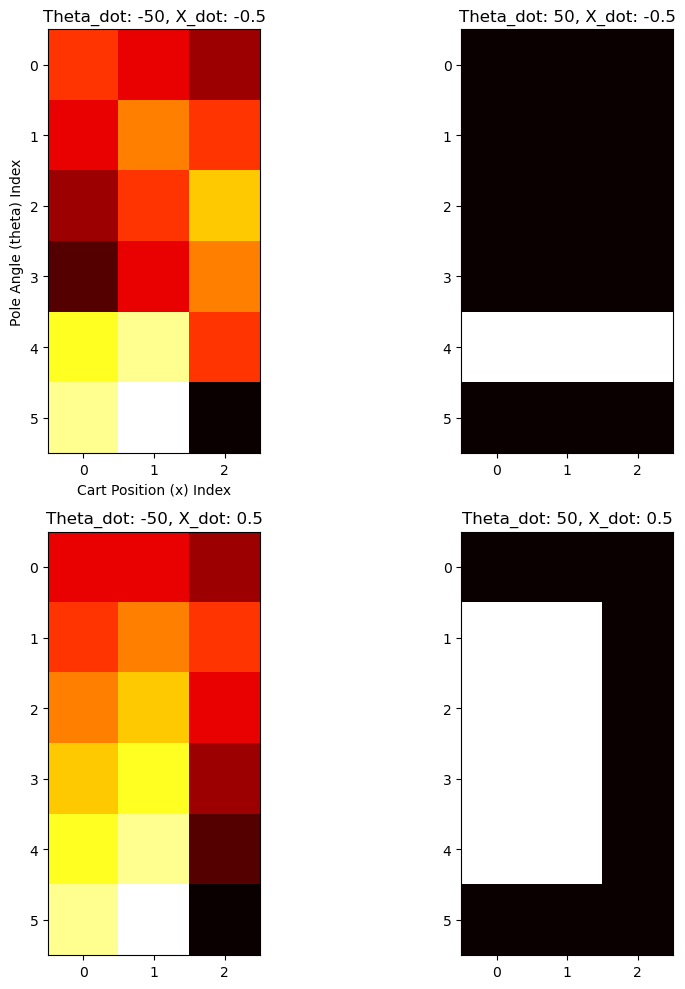

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots

# Plot for theta_dot: -50, x_dot: -0.5
axs[0, 0].imshow(optimal_state_values[:, :, 0, 0], cmap='hot', interpolation='nearest')
axs[0, 0].set_title('Theta_dot: -50, X_dot: -0.5')
axs[0, 0].set_xlabel('Cart Position (x) Index')
axs[0, 0].set_ylabel('Pole Angle (theta) Index')

# Plot for theta_dot: 50, x_dot: -0.5
axs[0, 1].imshow(optimal_state_values[:, :, 1, 0], cmap='hot', interpolation='nearest')
axs[0, 1].set_title('Theta_dot: 50, X_dot: -0.5')

# Plot for theta_dot: -50, x_dot: 0.5
axs[1, 0].imshow(optimal_state_values[:, :, 0, 1], cmap='hot', interpolation='nearest')
axs[1, 0].set_title('Theta_dot: -50, X_dot: 0.5')

# Plot for theta_dot: 50, x_dot: 0.5
axs[1, 1].imshow(optimal_state_values[:, :, 1, 1], cmap='hot', interpolation='nearest')
axs[1, 1].set_title('Theta_dot: 50, X_dot: 0.5')

# Show the plots
plt.tight_layout()  # Adjust the layout
plt.show()


In [1]:
# Plot the optimal state values and policy (same plotting code as provided)
# Plot policy
def plot_policy(policy):
    # Reduce the 4D policy array to 2D by selecting the action with the highest probability
    policy_2d = np.argmax(policy, axis=-1).sum(axis=(2, 3))
    plt.figure(figsize=(8, 6))
    plt.imshow(policy_2d, cmap='hot', interpolation='nearest')
    plt.xlabel('Cart Position (x) Index')
    plt.ylabel('Pole Angle (theta) Index')
    plt.title('Heatmap of Optimal Policy')
    plt.xticks(np.arange(len(x_bins)), labels=[f'{bin:.2f}' for bin in x_bins])
    plt.yticks(np.arange(len(theta_bins)), labels=[f'{bin:.2f}' for bin in theta_bins])

    plt.colorbar()
    plt.show()
    
plot_policy(optimal_policy)

NameError: name 'optimal_policy' is not defined

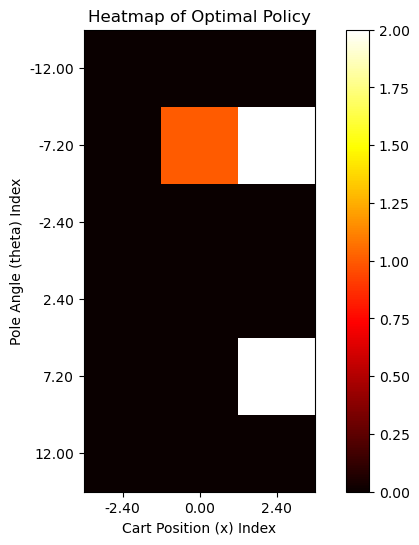

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
M = 1.0  # mass of the cart
m = 0.1  # mass of the pole
g = 9.8  # acceleration due to gravity, positive for the direction
l = 0.5  # half-length of the pole
mu_c = 0.0005  # coefficient of friction of the cart
mu_p = 0.00002  # coefficient of friction of the pole
actions = np.array([10, -10])  # possible actions (force on the cart)
delta_t = 0.02  # time step for integration
gamma = 0.99  # discount factor

# Discretization of the state space
theta_bins = np.linspace(-12, 12, 6)  # theta discretization
x_bins = np.linspace(-2.4, 2.4, 3)  # x discretization
theta_dot_bins = np.array([-50, 50])  # theta_dot discretization (open-ended)
x_dot_bins = np.array([-0.5, 0.5])  # x_dot discretization (open-ended)

# Initialize policy and value function
policy = np.zeros((len(theta_bins), len(x_bins), len(theta_dot_bins), len(x_dot_bins), len(actions)))
for i in range(len(theta_bins)):
    for j in range(len(x_bins)):
        for k in range(len(theta_dot_bins)):
            for l in range(len(x_dot_bins)):
                policy[i, j, k, l] = np.array([0.5, 0.5])  # Initialize with a random policy
state_values = np.zeros((len(theta_bins), len(x_bins), len(theta_dot_bins), len(x_dot_bins)))

# Define the reward function
def reward(theta, x):
    if abs(theta) <= 12 and abs(x) <= 2.4:
        return 1  # Reward for keeping the pole balanced
    else:
        return -1  # Penalty for failing to keep the pole balanced

# Define the dynamics of the system
def dynamics(theta, x, theta_dot, x_dot, force):
    sin_theta = np.sin(np.radians(theta))
    cos_theta = np.cos(np.radians(theta))
    theta_ddot = (g * sin_theta + cos_theta * (-force - m*l*theta_dot**2*sin_theta + mu_c * np.sign(x_dot)) / (M + m)) / \
                 (l * (4/3 - m*cos_theta**2 / (m + M)))
    x_ddot = (force + m*l*(theta_dot**2*sin_theta - theta_ddot*cos_theta) - mu_c*np.sign(x_dot)) / (M + m)
    return theta_ddot, x_ddot

# Policy Iteration Algorithm
def policy_iteration(policy, state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins, discount_factor=1.0, max_iterations=1000):
    is_value_changed = True
    iterations = 0
    while is_value_changed and iterations < max_iterations:
        is_value_changed = False
        iterations += 1
        # Policy Evaluation
        for i in range(len(theta_bins)):
            for j in range(len(x_bins)):
                for k in range(len(theta_dot_bins)):
                    for l in range(len(x_dot_bins)):
                        v = state_values[i, j, k, l]
                        action_values = np.zeros(len(actions))
                        for action_index, action in enumerate(actions):
                            theta_ddot, x_ddot = dynamics(theta_bins[i], x_bins[j], theta_dot_bins[k], x_dot_bins[l], action)
                            # Update state with Euler's method
                            new_theta_dot = theta_dot_bins[k] + theta_ddot * delta_t
                            new_x_dot = x_dot_bins[l] + x_ddot * delta_t
                            new_theta = theta_bins[i] + new_theta_dot * delta_t
                            new_x = x_bins[j] + new_x_dot * delta_t
                            # Discretize new state
                            new_i = min(len(theta_bins) - 1, max(0, np.digitize(new_theta, theta_bins) - 1))
                            new_j = min(len(x_bins) - 1, max(0, np.digitize(new_x, x_bins) - 1))
                            new_k = 0 if new_theta_dot < 0 else 1
                            new_l = 0 if new_x_dot < 0 else 1
                            # Calculate the action value
                            action_values[action_index] = reward(new_theta, new_x) + discount_factor * state_values[new_i, new_j, new_k, new_l]
                        # Select the best action value and update the value function
                        best_action_value = np.max(action_values)
                        state_values[i, j, k, l] = best_action_value
                        # Update the policy
                        best_action = np.argmax(action_values)
                        if policy[i, j, k, l][best_action] != 1.0:
                            is_value_changed = True
                        policy[i, j, k, l] = np.eye(len(actions))[best_action]

        # Policy Improvement
        for i in range(len(theta_bins)):
            for j in range(len(x_bins)):
                for k in range(len(theta_dot_bins)):
                    for l in range(len(x_dot_bins)):
                        old_action = np.argmax(policy[i, j, k, l])
                        action_values = np.zeros(len(actions))
                        for action_index, action in enumerate(actions):
                            theta_ddot, x_ddot = dynamics(theta_bins[i], x_bins[j], theta_dot_bins[k], x_dot_bins[l], action)
                            # Update state with Euler's method
                            new_theta_dot = theta_dot_bins[k] + theta_ddot * delta_t
                            new_x_dot = x_dot_bins[l] + x_ddot * delta_t
                            new_theta = theta_bins[i] + new_theta_dot * delta_t
                            new_x = x_bins[j] + new_x_dot * delta_t
                            # Discretize new state
                            new_i = min(len(theta_bins) - 1, max(0, np.digitize(new_theta, theta_bins) - 1))
                            new_j = min(len(x_bins) - 1, max(0, np.digitize(new_x, x_bins) - 1))
                            new_k = 0 if new_theta_dot < 0 else 1
                            new_l = 0 if new_x_dot < 0 else 1
                            # Calculate the action value
                            action_values[action_index] = reward(new_theta, new_x) + discount_factor * state_values[new_i, new_j, new_k, new_l]
                        # Update the policy
                        best_action = np.argmax(action_values)
                        if best_action != old_action:
                            is_value_changed = True
                        policy[i, j, k, l] = np.eye(len(actions))[best_action]
    return policy, state_values

# Run the policy iteration
optimal_policy, optimal_state_values = policy_iteration(policy, state_values, theta_bins, x_bins, theta_dot_bins, x_dot_bins)

# Plot the optimal state values and policy (same plotting code as provided)
# Plot policy
def plot_policy(policy):
    # Reduce the 4D policy array to 2D by selecting the action with the highest probability
    policy_2d = np.argmax(policy, axis=-1).sum(axis=(2, 3))
    plt.figure(figsize=(8, 6))
    plt.imshow(policy_2d, cmap='hot', interpolation='nearest')
    plt.xlabel('Cart Position (x) Index')
    plt.ylabel('Pole Angle (theta) Index')
    plt.title('Heatmap of Optimal Policy')
    plt.xticks(np.arange(len(x_bins)), labels=[f'{bin:.2f}' for bin in x_bins])
    plt.yticks(np.arange(len(theta_bins)), labels=[f'{bin:.2f}' for bin in theta_bins])

    plt.colorbar()
    plt.show()
    
plot_policy(optimal_policy)